In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

In [2]:
# 加载图像
image = cv2.imread('../../data/imgs/0618.png')
# 转换为RGB格式（opencv读取为BGR）
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
# 加载生成的掩码
mask = cv2.imread('../../data/imgs/mask0618.png', cv2.IMREAD_GRAYSCALE)

In [4]:
Y = mask.flatten()
Y = np.where(Y > 128, 1, 0)  # 1为道路，0为非道路
# 将数组转换为Pandas Series
series = pd.Series(Y)
# 使用value_counts方法统计每个元素的出现次数
value_counts = series.value_counts()
# 输出分布情况
print(value_counts)

1    73382
0    51618
Name: count, dtype: int64


In [5]:
# 获取图像的尺寸
h, w, _ = image_rgb.shape
# 将掩码展开为一维向量
# Y = mask.flatten()
# Y = np.where(Y > 128, 1, 0)  # 1为道路，0为非道路
# 转换到HSV颜色空间
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# 转换到灰度图像
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# 构建特征向量 (R, G, B, H, S, V, x, y, contrast, dissimilarity, homogeneity, energy, correlation, ASM)
X = []
for i in range(h):
    for j in range(w):
        pixel = image_rgb[i, j]
        hsv_pixel = image_hsv[i, j]
        
        # 获取当前像素点的纹理特征
        
        X.append([
            pixel[0], pixel[1], pixel[2], 
            hsv_pixel[0], hsv_pixel[1], hsv_pixel[2], 
            i, j,
        ])

# 将 X 转换为 numpy 数组
X = np.array(X)

# 打印特征向量的形状
print("Feature vector shape:", X.shape)
print(X)


Feature vector shape: (125000, 8)
[[  3   3   3 ...   3   0   0]
 [ 11  11  11 ...  11   0   1]
 [ 10  10  10 ...  10   0   2]
 ...
 [ 87  83  87 ...  87 249 497]
 [ 88  84  87 ...  88 249 498]
 [ 20  17  19 ...  20 249 499]]


In [6]:
# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# 归一化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(87500, 8)

In [9]:
# 创建SVM分类器
clf = svm.SVC(kernel='rbf')  # 使用线性核

# 训练SVM分类器
clf.fit(X_train, Y_train)

# 在测试集上评估模型
predictions = clf.predict(X_test)
# print("Accuracy:", accuracy_score(Y_test, predictions))
# 
# # 计算评价指标
# accuracy = accuracy_score(Y_test, predictions)
# precision = precision_score(Y_test, predictions, average='weighted')  # 使用加权平均
# recall = recall_score(Y_test, predictions, average='weighted')        # 使用加权平均
# f1 = f1_score(Y_test, predictions, average='weighted')                # 使用加权平均
# conf_matrix = confusion_matrix(Y_test, predictions)
# 
# # 输出评价指标
# print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
# print(f'F1 Score: {f1:.4f}')
# print('Confusion Matrix:\n', conf_matrix)
# 
# print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:\n", cm)

# 手动计算各项指标
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

Confusion Matrix:
 [[15163   354]
 [  277 21706]]
Accuracy: 0.9831733333333333
Precision: 0.9839528558476881
Recall: 0.9873993540463085
Specificity: 0.9771863117870723
F1 Score: 0.9856730922053447


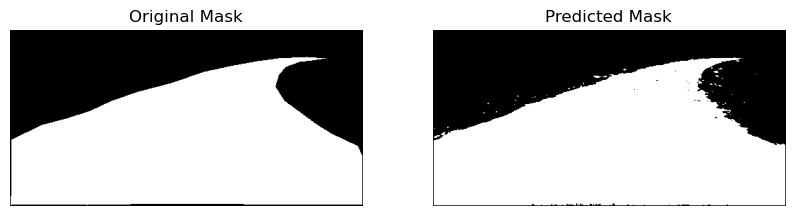

In [8]:
# 生成预测结果的图像
predicted_mask = np.zeros_like(mask)
for i in range(h):
    for j in range(w):
        pixel = image_rgb[i, j]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_RGB2HSV)[0, 0]
        feature_vector = np.array([
            pixel[0], pixel[1], pixel[2],
            hsv_pixel[0], hsv_pixel[1], hsv_pixel[2],
            i, j,
        ]).reshape(1, -1)
        feature_vector = scaler.transform(feature_vector)
        predicted_mask[i, j] = clf.predict(feature_vector)[0]

# 显示预测结果的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()